In [1]:
emotion='familiarity'
data_file='s07'
with_or_without='yes'#don't change #preprocessing

In [2]:
import os
import pickle
import numpy as np
import pandas as pd
import sys

from keras.layers import Conv2D, Dense, Flatten, ELU, BatchNormalization, LSTMCell, StackedRNNCells,\
    RNN, Permute, Dropout, Concatenate, Input, concatenate, Lambda, Reshape, Lambda

from keras import backend as K
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers.merge import add


from keras.callbacks import ModelCheckpoint

from keras.models import load_model
import matplotlib.pyplot as plt

Using TensorFlow backend.


---------------------------------------------------
yes familiarity s07
---------------------------------------------------

loaded shape: (2400,)
cnn_datasets.shape,rnn_datasets.shape,labels.shape :  (2400, 128, 9, 9) (2400, 128, 32) (2400, 2)
(2400, 9, 9, 128)
cnn_datasets.shape :  (2400, 9, 9, 128)
================================ DNN ============================================
input_cnn:  (None, 9, 9, 128)
elu1:  (None, 9, 9, 32)
elu2:  (None, 9, 9, 64)
elu3:  (None, 9, 9, 128)
reshape1:  (None, 9, 9, None)
elu4:  (None, 9, 9, 13)
reshape2:  (None, 1053)
input_rnn (None, 128, 32)
rnn_in_flat (None, None, 32)
rnn_fc_in (None, 128, 1024)
lstm_in (None, None, 1024)
lstm_cell (None, 32)
output (None, 32)
rnn_output (32,)
lstm_fc_out (None, 1024)
lstm_fc_drop (None, 1024)
fuse_cnn_rnn  (None, 2077)
(None, 2)
y  Tensor("dense_3/Softmax:0", shape=(None, 2), dtype=float32)
Model: "model_1"
__________________________________________________________________________________________________
L

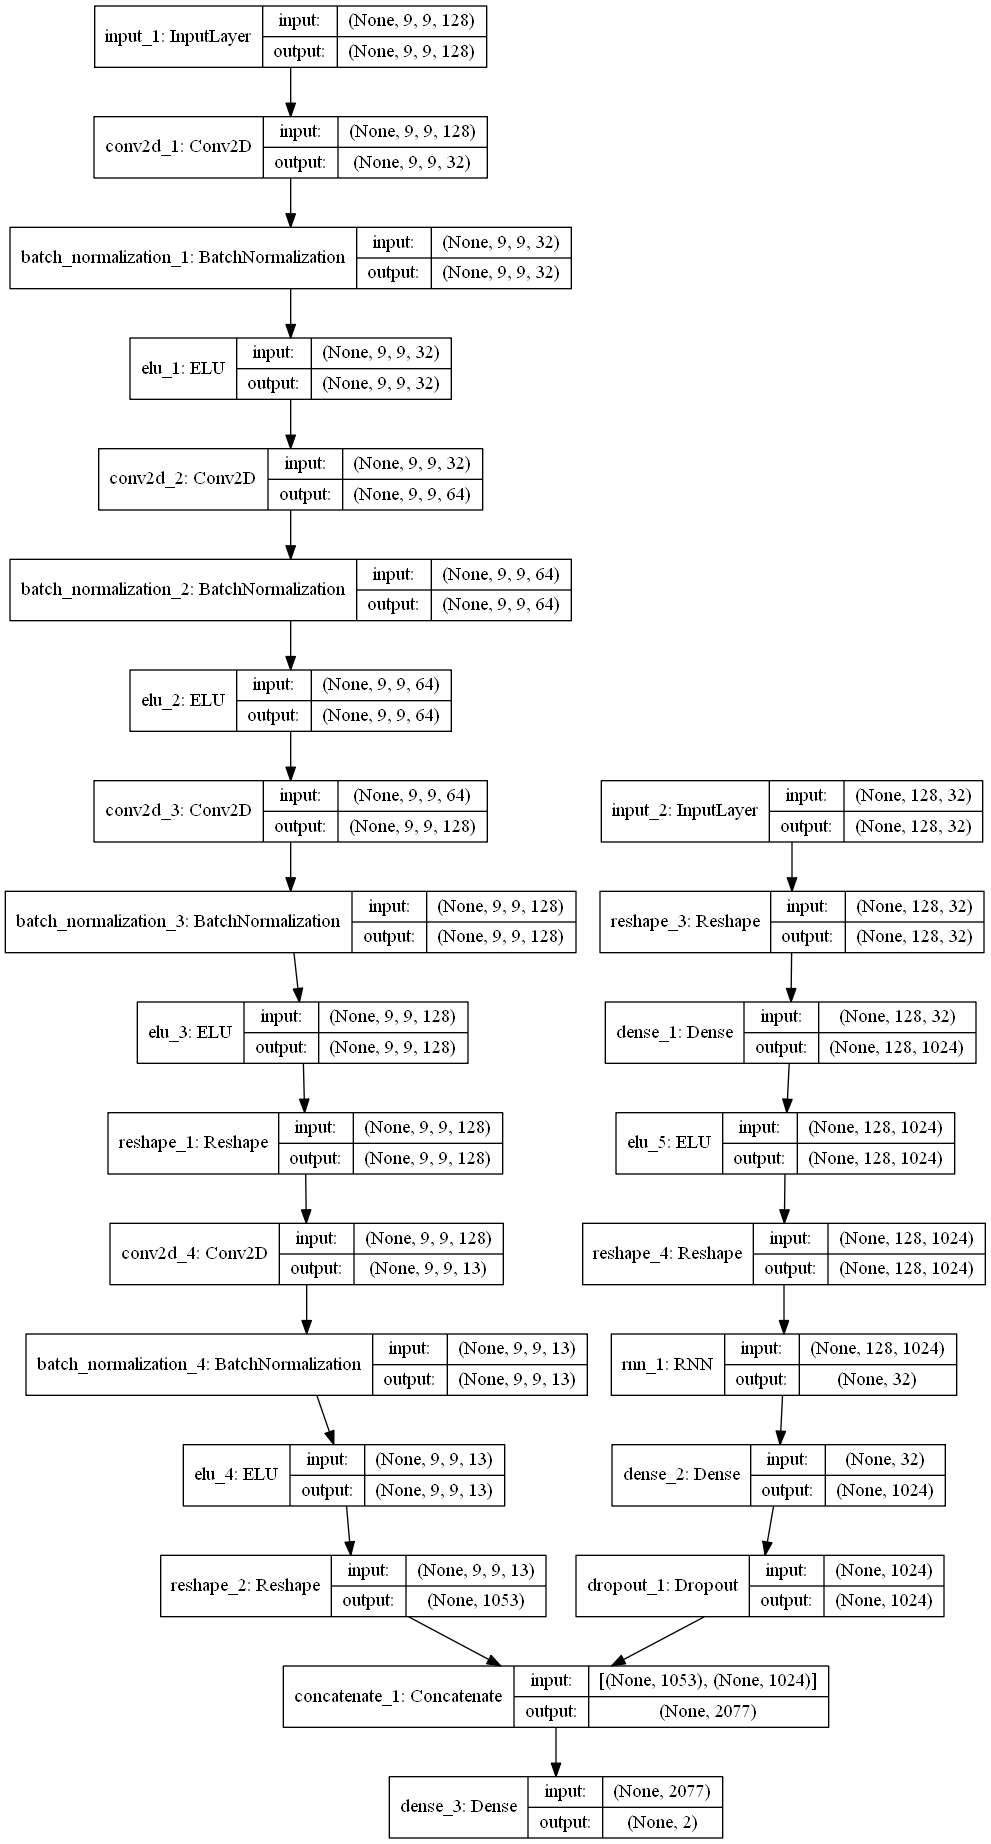

In [3]:
np.random.seed(32)

window_size = 128

cnn_suffix ='.mat_win_128_cnn_dataset.pkl'
rnn_suffix ='.mat_win_128_rnn_dataset.pkl'
label_suffix ='.mat_win_128_labels.pkl'

print('---------------------------------------------------')
print(with_or_without+' '+emotion+' '+data_file)
print('---------------------------------------------------\n')


dataset_dir = 'deap_shuffled_data/'+with_or_without+'_'+emotion+'/'
###load training set
try:
    with open(dataset_dir + data_file + cnn_suffix, "rb") as fp:
        cnn_datasets = pickle.load(fp)
    with open(dataset_dir + data_file + rnn_suffix, "rb") as fp:
        rnn_datasets = pickle.load(fp)
    with open(dataset_dir + data_file + label_suffix, "rb") as fp:
        labels = pickle.load(fp)
        labels = np.transpose(labels)
        print("loaded shape:",labels.shape)
except:
    print('data file of this subject isnt available')
    exit()
    
lables_backup = labels

one_hot_labels = np.array(list(pd.get_dummies(labels)))

labels = np.asarray(pd.get_dummies(labels), dtype=np.int8)

# shuffle data
index = np.array(range(0, len(labels)))
np.random.shuffle(index)

cnn_datasets   = cnn_datasets[index]
rnn_datasets   = rnn_datasets[index]
labels  = labels[index]

print('cnn_datasets.shape,rnn_datasets.shape,labels.shape : ',cnn_datasets.shape,rnn_datasets.shape,labels.shape)
#important
cnn_datasets=cnn_datasets.reshape(2400,9,9,-1)# imp
print(cnn_datasets.shape)
print('cnn_datasets.shape : ',cnn_datasets.shape)


print('================================ DNN ============================================')

input_cnn=Input(shape=(9,9,128))

print('input_cnn: ',input_cnn.shape)

conv1=Conv2D(32,
              kernel_size=(4,4),
              strides=(1,1),
              padding='same',
              input_shape=(9,9,128)
             )(input_cnn)


bn1=BatchNormalization()(conv1)

elu1=ELU()(bn1)

print('elu1: ',elu1.shape)
#?,9,9,32
conv2=Conv2D(64,
              kernel_size=(4,4),
              strides=(1,1),
              padding='same'
             )(elu1)

bn2=BatchNormalization()(conv2)

elu2=ELU()(bn2)

print('elu2: ',elu2.shape)
#?,9,9,64

conv3=Conv2D(128,
              kernel_size=(4,4),
              strides=(1,1),
              padding='same'
             )(elu2)

bn3=BatchNormalization()(conv3)

elu3=ELU()(bn3)


print('elu3: ',elu3.shape)
#?,9,9,128

# mc.add(Flatten())
# mc.add(Lambda(lambda x:x,output_shape=(9,9,32*4*128)))
# mc.add(Lambda(K.reshape((-1,9,9,32*4*128))))
reshape1=Reshape((9,9,-1))(elu3)


print('reshape1: ',reshape1.shape)
#?,9,9,32*4*128

conv4=Conv2D(13,#32*4*128,
              kernel_size=(1,1),
              strides=(1,1),
              padding='same'
             )(reshape1)

bn4=BatchNormalization()(conv4)

elu4=ELU()(bn4)


print('elu4: ',elu4.shape)
#?,9,9,13 #32*4*128

# mc.add(Flatten())

# mc.add(Lambda(lambda x:x,output_shape=([13*9*9])))
# mc.add(Lambda(K.reshape((None,13*9*9))))
reshape2=Reshape(([13*9*9]))(elu4)


print('reshape2: ',reshape2.shape)




cnn_out_fuse=reshape2


# cube=K.reshape(e3,(-1,9,9,32*4*128))#(e3)


# flat=K.reshape(e4,(-1,13*9*9))#(e4) #1053

# rnn_in=K.placeholder(shape=(None,128,32))
# rnn_in=tf.convert_to_tensor(rnn_datasets,dtype='float32')


# rnn_in.get_shape().as_list()

# rnn_in=K.placeholder(shape=(None,128,32))
# rnn_in_flat=K.reshape(rnn_in,[-1,32])

# print('rnn_in ',rnn_in.shape)

input_rnn=Input(shape=(128,32))
print('input_rnn',input_rnn.shape)

rnn_in_flat=Reshape((-1,32))(input_rnn)
print('rnn_in_flat',rnn_in_flat.shape)
# rnn_in_flat = Lambda(lambda x:x[:,0])(input_rnn)

# rnn_fc_in1 =Dense(32)(rnn_in_flat)
rnn_fc_in1 =Dense(1024)(rnn_in_flat)
rnn_fc_in=ELU()(rnn_fc_in1)
print('rnn_fc_in',rnn_fc_in.shape)

# rnn_fc_in =Dense(1024)(input_rnn)

# lstm_in=Reshape((-1,128,1024))(rnn_fc_in)
lstm_in=Reshape((-1,1024))(rnn_fc_in)
print('lstm_in',lstm_in.shape)

cells=[]

for i in range(2):
    cell=LSTMCell(32,unit_forget_bias=True,dropout=0.5)#'forget_bias'=1.0,'state_is_tuple'=True
    cells.append(cell)
#     print(cell.shape)

# lstm_cell=StackedRNNCells(cells)
lstm_cell=RNN(cells)(lstm_in)
# print(lstm_cell.shape)
# op,states=RNN(cells)(lstm_in)
print('lstm_cell',lstm_cell.shape)
# output=K.transpose_shape((1,0,2),lstm_cell)
# output=Permute((1,0,2))(lstm_cell)
# output.reshape()
output=lstm_cell
print('output',output.shape)
rnn_output=output[-1]
# rnn_output

print('rnn_output',rnn_output.shape)
# shape_rnn_out=rnn_output.get_shape().as_list()
lstm_fc_out=Dense(1024)(output)#shape_rnn_out[1]

print('lstm_fc_out',lstm_fc_out.shape)


# lstm_fc_out_2=Dense(1053)(lstm_fc_out)#shape_rnn_out[1]



lstm_fc_drop=Dropout(0.5)(lstm_fc_out)
# lstm_fc_drop
print('lstm_fc_drop',lstm_fc_drop.shape)

# fuse_cnn_rnn=add([cnn_out_fuse,lstm_fc_drop])

fuse_cnn_rnn=concatenate([cnn_out_fuse,lstm_fc_drop])
print('fuse_cnn_rnn ',fuse_cnn_rnn.shape)
y=Dense(2,activation='softmax')(fuse_cnn_rnn) ## ,activity_regularizer=regularizers.l2(0.5)
print(y.shape)
y_pred=K.argmax(y,1)
# y_pred=K.argmax(K.softmax(y))
# y_posi=K.softmax(y)
print('y ',y)


# directory_le007a='./lightningedge007a_results/'+with_or_without+'/'+arousal_or_valence+'/'+data_file
# try:
#     if not os.path.exists(directory_le007a):
#         os.makedirs(directory_le007a)
# except OSError:
#     print ('Error: Creating directory. ' +  directory_le007a)



model=Model(inputs=[input_cnn,input_rnn],outputs=y)
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

print(model.summary())



# tb_log_dir='lightningedge007a_results\\'+with_or_without+'\\'+arousal_or_valence+'\\'+data_file+'\\'+'logs_'+with_or_without+'_'+arousal_or_valence+'_'+data_file
# createFolder(tb_log_dir)


#log_dir='lightningedge007a_results\\'+with_or_without+'\\'+arousal_or_valence+'\\'+data_file+'\\'+'logs_'+with_or_without+'_'+arousal_or_valence+'_'+data_file+'_'+str(curr_fold)+'_fold\\' #datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = callbacks.TensorBoard(log_dir=tb_log_dir)#, histogram_freq=1)

# plotpicture=plot_model(model, to_file='lightningedge007a_results/'+with_or_without+'/'+arousal_or_valence+'/'+data_file+'/'+'model_'+with_or_without+'_'+arousal_or_valence+'_'+data_file+'.png', show_shapes=True)
#
# plot_model(model,show_shapes=True)
#history=model.fit([cnn_train,rnn_train],labels_train,batch_size=128,epochs=50,callbacks=[tensorboard_callback,m_val_acc,m_val_loss],validation_split=0.2)


#Plot values
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('max_acc_'+with_or_without+'_'+arousal_or_valence+'_'+data_file)
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper right',bbox_to_anchor=(1.3,1))
# plt.savefig('lightningedge007a_results/'+with_or_without+'/'+arousal_or_valence+'/'+data_file+'/'+'max_acc_'+with_or_without+'_'+arousal_or_valence+'_'+data_file+'.png',bbox_inches='tight')
# #plt.show()
# plt.close()
# print(plotpicture)

# Plot training & validation loss values
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('min_loss_'+with_or_without+'_'+arousal_or_valence+'_'+data_file+'_'+str(curr_fold)+'_fold')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper right',bbox_to_anchor=(1.3,1))
# plt.savefig('lightningedge007a_results/'+with_or_without+'/'+arousal_or_valence+'/'+data_file+'/'+'min_loss_'+with_or_without+'_'+arousal_or_valence+'_'+data_file+'.png',bbox_inches='tight')
# #plt.show()
# plt.close()
plot_model(model,show_shapes=True)


In [4]:
vam=load_model('lightningedge007a_results/'+with_or_without+'/'+emotion+'/'+data_file+'/'+'max_acc_'+with_or_without+'_'+emotion+'_'+data_file+'.h5')
vlm=load_model('lightningedge007a_results/'+with_or_without+'/'+emotion+'/'+data_file+'/'+'min_loss_'+with_or_without+'_'+emotion+'_'+data_file+'.h5')
# pred_labels=vam()
vam_eval=vam.evaluate([cnn_datasets,rnn_datasets],labels)
print('max acc: ',vam_eval)

print('Loss : ',vam_eval[0])
print('Accuracy : ',vam_eval[1])

vlm_eval=vlm.evaluate([cnn_datasets,rnn_datasets],labels)
print('min loss: ',vlm_eval)

print('Loss : ',vlm_eval[0])
print('Accuracy : ',vlm_eval[1])


2400/2400 [==============================] - 8s 3ms/step
max acc:  [0.018870535921305418, 0.9962499737739563]
Loss :  0.018870535921305418
Accuracy :  0.9962499737739563
2400/2400 [==============================] - 7s 3ms/step
min loss:  [0.008735355118891069, 0.9958333373069763]
Loss :  0.008735355118891069
Accuracy :  0.9958333373069763


# The Hybrid-DNN predicts the particular emotion at every second for every movie with above accuracy for the given user for over 40 video clips of 60 sec each (40*60=2400)